### University of Stirling
#### Computing Science and Mathematics
#### CSCU9YE - Artificial Intelligence
#### student ID number: 292 53 99

# Coursework: The Multi-dimensional Knapsack Problem
The multi-dimensional knapsack problem is an optimisation problem where the goal is to maximise the total value or profit of a set of items.

It can be seen as an extension of the single knapsack problem, but instead of having a single constraint (a single sack), we can have two or more constraints.

It is better to think in terms of constraints or resources (rather than sacks) to understand this problem.   

The following data provides an instance of the multi-dimensional knapsack problem.

n = number of possible items
m = number of constraints

A list of length n with the profits or values of each item
A list of length m with the amounts of each constraint or resource

An n x m matrix with the "weight" or "use" of item i in constraint j

In mathematical terms, the problem can be formulated as follows:

Maximise sum of p(j)s(j)  for j = 1,...,n

Subject to  sum of r(i,j)s(j) <= b(i)  for i=1,...,m and j = 1,...,n

Where, 

       s is a binary vector s(j)=0 or 1
       p is the vector of profits
       r is the matrix of resource coefficients (weights)
       b is the vector with resource capacities
       
   
Let us make this more concrete with an example.

Let us assume we have a pizza shop.

We have the recipes of n different toppings pizzas that we can produce.
Each of the n pizzas has a value or profit, we can think of it as its selling price.

But we have limited resources! In this case ingredients, so we cannot produce all the n pizza recipes.

This means that we need to select a subset of the n pizza recipes that maximises our profit.

Let us assume that for producing the pizzas we have m required ingredients (eg. flour, cheese, olives, ham, mushrooms, pineapple, etc), for each of them we have a fixed amount.

Each of the n pizza recipes uses a certain amount of the m ingredients (note: it can be zero for some of them).

Our task is to select the subset of the n pizza recipes *with the highest value/profit* subject to the constraints imposed by the amounts of the m ingredients we have.

## Aquiring the problem data

-  This function reads the data of a given problem instance
-  It returns four variables in the the following order, using the variable names as in the mathematical formulation described in the coursework
    - *n*: number of items, 
    - *m*: number of constraints
    - *p*: one dimensional numpy array with the profit coefficients fore ach item 
    - *r*: two dimensional numpy array with the resource coefficients for each item on each constraint/resource
    - *b*: one dimensional numpy array with the constraints right-hand size, that is the bounds or capacities 


In [1]:
import numpy as np

def read_multi_knapsack(fname):
    """
    Reads the data of a multi-knapsack instance

    :param fname: file name with instance data
    :return: n, m, p, r and b (as described above)
    """ 
    profits = []
    with open(fname, 'r') as kfile:
        lines = kfile.readlines()
        
    # convert m,n  to integer varaibles   
    n, m  = [int(d) for d in lines[0].split()]   # convert string data to integers
        
    input_line_cnt = 1    # input lines index after first line
    p = np.empty(0, dtype=np.int64)
    while p.size < n:
        d = np.loadtxt(lines[input_line_cnt].split(),
                       delimiter=" ", dtype=np.int64)
        p = np.append(p, d)
        input_line_cnt += 1

    r = np.empty((0, n), dtype=np.int64)
    for i in range(m):
        lin = np.empty(0, dtype=np.int64)
        while lin.size < n:
            d = np.loadtxt(lines[input_line_cnt].split(),
                           delimiter=" ", dtype=np.int64)
            lin = np.append(lin, d)
            input_line_cnt += 1
        r = np.vstack((r, lin))

    # get the capacities (max of one line space separated integer values)
    b = np.loadtxt(lines[input_line_cnt].split(),
                     delimiter=" ", dtype=np.int64)

    return  n, m, p, r, b, 


### Reading the data from the file

In [2]:
data_file_name = "multi_knap_n28_m2.txt"        

n, m, profits, resources, capacities = read_multi_knapsack(data_file_name)

print("Instance Data:")
print(f"n: {n}.  m: {m}")
print(f"Profits: {profits}")
print(f"Resources: {resources}")
print(f"Capacities: {capacities}")


Instance Data:
n: 28.  m: 2
Profits: [ 1898   440 22507   270 14148  3100  4650 30800   615  4975  1160  4225
   510 11880   479   440   490   330   110   560 24355  2885 11748  4550
   750  3720  1950 10500]
Resources: [[ 45   0  85 150  65  95  30   0 170   0  40  25  20   0   0  25   0   0
   25   0 165   0  85   0   0   0   0 100]
 [ 30  20 125   5  80  25  35  73  12  15  15  40   5  10  10  12  10   9
    0  20  60  40  50  36  49  40  19 150]]
Capacities: [500 500]


# Part 1: Simple Hill-Climbing
Total: 10 marks (20% of 50 point total):
Code, Experiments and Results -
Code for hill-climbing, including fitness function
Modularity, conciseness, clarity, elegance, comments
Running experiments and reporting results

- Implement a fitness  (evaluation) function. That is a function, that measures the quality of a solution. 
- Implement a function that checks the validity of a solution. 
- Using the functions above, implement a simple hill-climbing search method to solve this problem. 
- Using the instance with n = 28 and m = 2, run experiments and report the results obtained using both numerical metrics and plots. 

## Understanding the problem
In simple terms, you have 28 pizza recipes to choose from, and each pizza can have any number of ingredients. However, you must be careful not to use too much of the specific ingredients (cheese and tomato for example) because you have limited quantities of these ingredients. Your goal is to pick pizzas that maximize your profit without breaking these ingredient constraints.
### What are the inputs?
- n = numberOfRecipes = number of possible recipes (e.g. 5: number of pizza recipes)
- m = numberOfIngredients = number of ingredients (e.g. 2: cheese and tomato)
- profits = recipeProfits = list of profits associated with each recipe (e.g. 5bucks, 8bucks, etc.)
- resources = recipeIngredientsQuantities = list of lists of quantities of each ingredient for each recipe (e.g. cheese[3, 5, 0, 3, 8], tomato[4, 1, 3, 2 , 0])
- capacities = ingredientsSupply = list of supplies for each ingredient (e.g. cheese: 50, tomato: 32)
So, the first recipe (pizza) in the profits list (profits[0]) has a value/profit of 5 bucks and requires 3 units of cheese and 4 units of tomato to make (cheese[0] = 3 and tomato[0] = 4).
### what is the desired output?
The objective is to come up with an array of pizza recipes with the highest possible profit value for the quantity of ingredients that we have.
- A single array of length n = numberOfRecipes where each value represents the quantity of a recipe in the profits array. The objective is to find the selection of recipes which generate the most profit with the ingredients available.

### Create variables with names that describe what they contain more clearly to me


In [3]:
numberOfRecipes = n
numberOfIngregients = m
recipeProfits = profits
recipeIngredientsQuantities = resources
ingredientsSupply = capacities

## 1.1: Implement a fitness (evaluation) function. That is a function, that measures the quality of a solution.

In [4]:
def getProfit(solution):
    '''
       Returns the value of a solution, i.e., its fitness
       Input: the solution list
       Output: total profit value
    '''
    totalProfit = 0
    totalIngredient1 = 0
    totalIngredient2 = 0
    for recipe in range(len(solution)):
        if solution[recipe] == 1:
            totalProfit = totalProfit + recipeProfits[recipe]
            totalIngredient1 = totalIngredient1 + recipeIngredientsQuantities[0][recipe]
            totalIngredient2 = totalIngredient2 + recipeIngredientsQuantities[1][recipe]
    maxIngredient1 = ingredientsSupply[0]
    maxIngredient2 = ingredientsSupply[1]
    if totalIngredient1 > maxIngredient1 or totalIngredient2 > maxIngredient2:
        totalProfit = 0
    return totalProfit

## 1.2 Implement a function that checks the validity of a solution.

In [5]:
def isValid(solution):
    '''
       Returns the validity of a solution as true or false
       Input: the solution list
       Output: true or false
    '''
    totalIngredient1 = 0
    totalIngredient2 = 0
    for recipe in range(len(solution)):
        if solution[recipe] == 1:
            totalIngredient1 = totalIngredient1 + recipeIngredientsQuantities[0][recipe]
            totalIngredient2 = totalIngredient2 + recipeIngredientsQuantities[1][recipe]
    maxIngredient1 = ingredientsSupply[0]
    maxIngredient2 = ingredientsSupply[1]
    if totalIngredient1 > maxIngredient1 or totalIngredient2 > maxIngredient2:
        valid = False
    else:
        valid = True
    return valid

## 1.3 Using the functions above, implement a simple hill-climbing search method to solve this problem.

### Generate solution function
The first thing I need is a function which generates a random solution.

In [6]:
import random as rnd

def randomSolution(length):
    '''
       Returns a random solution, binary list
       Input: lenght of the list
       Output: binary list
    '''
    randomSolution = rnd.choices([0, 1], weights = [60, 40], k = length)
    return randomSolution

### Random solution generation and evaluation test

In [7]:
aSolution = randomSolution(numberOfRecipes)
aValidity = isValid(aSolution)
aValue = getProfit(aSolution)
print(aSolution, aValue, aValidity)

[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0] 0 False


### Generate neighbour function
I will also need a funciton which generates a neighbour solution (1 bit flipped) from a given solution.

In [8]:
def generateNeighbour(solution):
    ''' Generate a random 1-bit flip neigbour of the given solution
        Input: solution as binary list
        Output: Solution in the 1-bit flip neighbourh
    ''' 
    neighbour = solution.copy()
    randomIndex = rnd.randint(0, numberOfRecipes - 1)
    if neighbour[randomIndex] == 0:
        neighbour[randomIndex] = 1
    else:
        neighbour[randomIndex] = 0
    return neighbour

### Neighbour function test

In [9]:
aNeighbour = generateNeighbour(aSolution)
print(aSolution, aNeighbour)

[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0] [1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0]


### Implementing the hill-climber algorithm
Now that I have functions which generate a random solution, evaluate said solution, and generate a neighbour of said solution, I can write a hill climber function which generates lots of neighbours starting with a random solution and returns the neighbour with the highest value at the end of all the iterations.

In [10]:
evaluate = getProfit

def hillClimber(iterations):
    ''' Hill climbing algorithm for a maximum number of iterations"
        Input: integer with the number of iterations to run
        Output: The solution at the end of hill-climing, its value
    '''
    solution = randomSolution(numberOfRecipes)
    solutionValue = evaluate(solution)
    for iteration in range(iterations):
        neighbour = generateNeighbour(solution)
        value = evaluate(neighbour)
        if value > solutionValue:
            solution = neighbour.copy()
            solutionValue = value
    return solution, solutionValue

### Hill climber algorithm test

In [11]:
hillClimberSolution, hillClimberSolutionValue = hillClimber(100)
print(hillClimberSolution, hillClimberSolutionValue)

[1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0] 85905


## 1.4 Using the instance with n = 28 and m = 2, run experiments and report the results obtained using both numerical metrics and plots.

To draw plots I want to make a version of my hill climber algorithm which keeps a history of my solution as it changes. This way I can trace the progression of my hill climber algorithm's solution and see the rate at which its fitness improves by plotting this information using pyplot.

In [12]:
def hillClimberWithTraces(iterations):
    ''' Hill climbing algorithm for a maximum number of iterations"
        Input: integer with the number of iterations to run
        Output: The solution at the end of hill-climing, its value, trace of all neighbours, trace of solutions, trace of iterations
    '''
    # the starting solution
    solution = randomSolution(numberOfRecipes)
    solutionValue = evaluate(solution)
    
    # setting up traces to trace the history of variable I want to keep track of
    allSolutionsProfitTrace = []
    allSolutionsProfitTrace.append(solutionValue)
    improvedSolutionsProfitTrace = []
    improvedSolutionsProfitTrace.append(solutionValue)
    improvedSolutionsIterationsTrace = []   
    improvedSolutionsIterationsTrace.append(0)
    
    # hill climber algorithm loop
    for iteration in range(iterations):
        neighbour = generateNeighbour(solution)
        value = evaluate(neighbour)
        allSolutionsProfitTrace.append(value)
        if value > solutionValue:
            solution = neighbour.copy()
            solutionValue = value
            improvedSolutionsProfitTrace.append(solutionValue)
            improvedSolutionsIterationsTrace.append(iteration + 1)
    return solution, solutionValue, allSolutionsProfitTrace, improvedSolutionsProfitTrace, improvedSolutionsIterationsTrace

### Testing the hill climber with traces function

In [13]:
iterations = 100
solution, solutionValue, allSolutionsProfitTrace, improvedSolutionsProfitTrace, improvedSolutionsIterationsTrace = hillClimberWithTraces(iterations)
print(solution, solutionValue, allSolutionsProfitTrace, improvedSolutionsProfitTrace, improvedSolutionsIterationsTrace)

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1] 76172 [66687, 67017, 71567, 61067, 0, 47212, 61067, 47212, 74452, 69902, 0, 70227, 75012, 74682, 0, 50657, 50657, 0, 73062, 74572, 74682, 72127, 73062, 0, 0, 70787, 64512, 63132, 0, 70462, 76172, 65672, 75012, 71622, 71622, 0, 51817, 0, 0, 75693, 64292, 0, 0, 0, 75732, 0, 64424, 64292, 0, 0, 75682, 75662, 76062, 0, 0, 0, 0, 75693, 0, 0, 0, 71947, 0, 73287, 71947, 0, 0, 73287, 75612, 51817, 0, 0, 75612, 71947, 75662, 75012, 65672, 0, 75732, 0, 71947, 0, 74222, 51817, 0, 64424, 0, 75693, 75732, 75682, 0, 75012, 65672, 0, 73287, 75732, 0, 71947, 75693, 73287, 0] [66687, 67017, 71567, 74452, 75012, 76172] [0, 1, 2, 8, 12, 30]


### Hill climber algorithm numerical metrics
The hill climber algorithm is a local search algorithm used for optimization problems. It is designed to find the highest point or the best solution within a given search space by iteratively exploring neighboring solutions. Let's explore the solutions found by the hill climber algorithm I just implemented.
We can look at the final solution of the hill climber algorithm and how many times better solutions were found compared to the first solution.

In [14]:
print("initial random solution fitness: ")
print(allSolutionsProfitTrace[0])
print()
print("final solution fitness")
print(improvedSolutionsProfitTrace[-1])
print()
print(f"number of times that a better solution was found over {iterations} iterations: " + str(len(improvedSolutionsProfitTrace) - 1))
print()
print(f"Iterations where a better solution was found: {improvedSolutionsIterationsTrace}")

initial random solution fitness: 
66687

final solution fitness
76172

number of times that a better solution was found over 100 iterations: 5

Iterations where a better solution was found: [0, 1, 2, 8, 12, 30]


### Using plots to report hill climber algorithm results
Using the pyplot library and the history of our hill climber solutions we can visualise the progression of the hill climber algortihm.
A great way to do this is by crossing a line plot and a scatter plot using the pyplot plot and scatter functions.
We can use the line plot to plot the solutions the algorithms finds to the problem every iteration, and we use the scatter plot to mark on the line plot exactly which iterations resulted in an improved solution.
This way we can see red Xs mared at iterations where the fitness increased and this makes the fitness improved rate easy to see too.

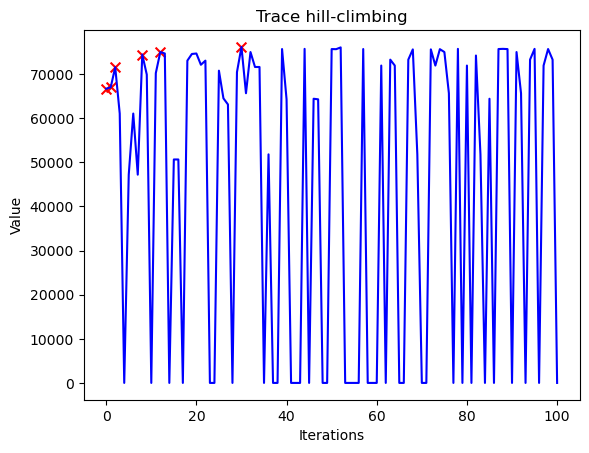

In [15]:
import matplotlib.pyplot as plt

plt.scatter(improvedSolutionsIterationsTrace, improvedSolutionsProfitTrace, color = "red", s = 50, marker = "x")
plt.plot(allSolutionsProfitTrace, color = "blue")
plt.title("Trace hill-climbing")
plt.ylabel("Value")
plt.xlabel("Iterations")
plt.show()

# Part 2: Algorithm of Your Choice
Total: 25 marks (50% of 50 point total)

15pts (30% of marks): 
Design Effort, Performance & Documentation -
A good algorithm requires design effort and produces good performance (find good solutions in a reasonably short time). Justify your design: algorithm, operators, components, parameters

10pts (20% of marks):
Code Quality -
Code for your own algorithm.
Modularity, conciseness, clarity, elegance, comments

- Here you're given the opportunity to design your own algorithm.
- The goal is to try to improve the performance of the simple hill-climbing method in Part 1.  
- Can you design an algorithm that improves the performance (finds better solutions) than hill-climbing?
- To do so, you can either use some of the algorithm ideas discussed in the lectures and/or try your own ideas. 

The marking on this part will be based on the following criteria
- Design Effort and Algorithm Performance: A good algorithm requires design effort and produces good performance (finding good solutions in a reasonably short time). 
- Implementation Quality: The clarity, modularity and conciseness of your code. 
- Documentation:  It is essential to document your design choices. 
    - You should provide in text form (using markdown cells in your notebook) brief descriptions of
        - The type of algorithm
        - The choice of search operator (s) or components you used, and their parameter values
        - Justify your choices when possible

## What's the goal here?
The goal here in part 2 is to write an algorithm which outperforms the local search hill climber algorithm from part 1 in this optimisation problem.
## For this task I have decided to implement a genetic algorithm.
A genetic algorithm works by mutating a population of solutions every iteration instead of just one solution. And it is called genetic because it performs evolutionary selection from the population each iteration by selecting the fittest individuals from the population and combining them in some way (called crossover) to make offspring which will populate the following iteration's population.
## Why will my selected genetic algorithm outperform the hill-climber algorithm from part 1?
Genetic algorrithms tend to fair better than hill climber algorithms when solving optimisation problems because genetic algorithms find solutions which converge to the global optimum solution, i.e., the best possible solution out of all the solutions. In comparison the hill climber algorithm converges to the local optimum solution, i.e., the best solution in a particular region of the search space, but not necessarily the best solution overall. 
This is because genetic algorithms explore a wider range of solutions compared to hill climber algorithms because instead of making small single bit changes to a solution until no further single bit improvements can be made, a genetic algorithm maintains candidate solutions and evolves them over time using genetic operators such as mutation, crossover, and selection. Crossover allows for the best parts of different solutions to be combined, thereby genetic algorithms don't get stuck converging to the local optimum solution. And selection is the operation which selects the best solutions from each iteration for reproduction, ensuring that solutions get better over time. The population based approach means that more possible solutions are explored every iteration compared to a hill climber algorithm.

### First I need a function which generates individuals to populate the starting population of the genetic algorithm

In [16]:
def createIndividual():
    '''
        Creates an individual as a list of two elements: solution and its fitness
    '''
    randSolution = randomSolution(numberOfRecipes)
    profit = getProfit(randSolution)
    return [randSolution, profit]

### Creating a starting population

In [17]:
def createPopulation(populationSize):
    '''
        Creates an initial population of populationSize randomly generated individuals
        Input:  an integer indicating the population size
        Output: a data structure for the population sorted by fitness
    '''
    population = [createIndividual() for i in range(populationSize)]
    population.sort(key = lambda x: x[1])  #key is set to sort using second element (profit, i.e., fitness) 
    return population

### Testing the create population function

In [18]:
populationSize = 10
testPopulation = createPopulation(populationSize)
print(testPopulation)

[[[1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0], 0], [[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1], 0], [[0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1], 0], [[0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1], 0], [[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 9385], [[0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0], 25072], [[1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0], 25933], [[0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1], 37624], [[0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0], 78350], [[0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0], 87475]]


### Implementing a mutation operator

In [19]:
def mutation(solution, numberOfMutations):
    ''' Generate a random 1-bit flip mutant of the given solution
        Input:  Solution as binary list
        Output: Mutated solution
    ''' 
    mutant = solution.copy() # copy solution
    genesToMutate = np.random.choice(np.arange(0, len(solution) - 1), # first arg indicates range of integers to choose from
                                     size = numberOfMutations, # second arg indicates how many integers to generate
                                     replace = False) # third arg 'replace' ensures that the same integer is not choosen twice
    for gene in genesToMutate:
        if mutant[gene] == 1:
            mutant[gene] = 0
        else:
            mutant[gene] = 1
    return mutant

## Why did I implement the mutation operation list this?
This mutation operation flips the value of numberOfMutations bits in a given solution. Thereby introducting new genetic material into the population. This increases the size of the search space of the genetic algorithm, i.e., the set of solutions it explores. By doing so the mutation operation helps prevent the genetic algorithm by getting stuck in a local optimum.

### Testing the mutation function

In [20]:
testSolution = testPopulation[3][0]
print(f"solution: ", testSolution)
testMutant = mutation(testSolution, 5)
print(f"mutant: ", testMutant)
print(f"test mutant length: {len(testMutant)}")

solution:  [0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1]
mutant:  [0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1]
test mutant length: 28


### Implementing a tournament selection operation which selects the individuals from the current population which will reproduce via the crossover operation and create offspring for the next generation of solutions.

In [21]:
getFitness = evaluate
def getFittest(participants):
    ''' Compares the fitness of participants the fittest individual
        input: the array of individuals to compare
        output: the solution (binary list) of the fittest individual
    '''
    fittest = participants[0]
    for participant in participants:
        if getFitness(participant) > getFitness(fittest):
            fittest = participant
    return fittest

def getParticipants(population, amount):
    ''' Returns the specified number of participants from the population
        input: the population to select the amount of individuals from
        output: array of amount specified random individuals in the population
    '''
    # make an array of random integers of length amount
    randomPositions = np.random.choice(np.arange(0, len(population) - 1), # first arg indicates range of integers to choose from
                                     size = amount, # second arg indicates how many integers to generate
                                     replace = False) # third arg 'replace' ensures that the same integer is not choosen twice
    participants = []
    for position in randomPositions:
        participants.append(population[position][0])
    return participants

def tournamentSelection(population, numberOfParticipants):
    ''' Compares the fitness of randomly selected individuals in the population and returns 
        the best individual
        Input:  the population data structure 
        ouptut: the solution (binary list) of the selected individual
    '''
    randomParticipants = getParticipants(population, numberOfParticipants)
    winner = getFittest(randomParticipants)
    return winner

### Testing the tournament selection operator

In [22]:
individualCounter = 0
for individual in testPopulation:
    individualCounter = individualCounter + 1
    print(f"individual {individualCounter} has a value of: {individual[1]}")
winner = tournamentSelection(testPopulation, 5)
print(winner)
print(evaluate(winner))

individual 1 has a value of: 0
individual 2 has a value of: 0
individual 3 has a value of: 0
individual 4 has a value of: 0
individual 5 has a value of: 9385
individual 6 has a value of: 25072
individual 7 has a value of: 25933
individual 8 has a value of: 37624
individual 9 has a value of: 78350
individual 10 has a value of: 87475
[0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0]
78350


## Why did I implement the selection operation like this?
The selection operation selects individuals from the current population to be used as parents for the next generation.
What is known as tournament selection is employed: a few individuals from the population are compared and the fittest among them are choosen as parents for the next generation.
The more participants in the selection process, the higher the selective pressure, i.e., the less likely weak candidates are to be choosen and the more likely stronger candidates will be choosen because the amount of competition is larger so weak candidates will have to compete against strong candidates.
The selection pressure parameter, i.e., the probability that a candidate participates in a tournament, is determined by the number of tournament participants and the size of the total populaiton. The selection pressure determines the rate of convergence of the algorithm. If the genetic algorithm's rate of convergence is too high it might converge towards an optimum solution too fast, thereby converging to a local optimum solution instead of the global optimum solution.
So, I need to be careful not to make the tournaments too competitive by not incrementing the number of participants too much. This way genetic diversity is maintained and the algorithm search space is larger.

### Implementing a crossover operation which will perform a crossover of two solutions, now that I have a mutation operation and a selection operation.

In [23]:
def crossover(parent1, parent2, numberOfCrossoverPoints):
    ''' Performs a numberOfCrossoverPoints-point crossover of the two given solutions
        Input:  Two solutions (binary lists) as parents
        Ouptut: One child applying n-point crossover.
    '''
    # an array of crossover points within the given parents
    crossoverPoints = np.random.choice(np.arange(1, len(parent1) - 2), size = numberOfCrossoverPoints, replace = False) 
        # Create an arry of random integers from given range without duplicates, i.e., replace = False
        # Crossover points are not first or last positions because those positions do not cross parent solutions
    crossoverPoints.sort() # Crossover points are sorted in ascending order so that child is the same length as parents
        
    #crossing over the parent solutions at the specified crossover points
    child = []
    previousPoint = 0
    nextParent = parent1
    for crossoverPoint in crossoverPoints:
        child = child + nextParent[previousPoint : crossoverPoint]
        if nextParent == parent1:
            nextParent = parent2
        else:
            nextParent = parent1  
        previousPoint = crossoverPoint # end of last subsection becomes start of next one
    
    # adding the last subsection of the child because the loop does not
    child = child + nextParent[previousPoint:]
    
    return child

## Why did I implement the crossover operation like this?
The crossover genetic operation is knows as the search operator. The serach operator is a function that takes one or more candidate solutions as input and produces one or more new candidate solutions as output.
This crossover operation performs an n-point crossover of the 
two given solutions.
This gives me the flexibility to change the number of crossover points so that I can experiment and see which number of crossover points gives me the best results when combining parent solutions.

### Testing the crossover operator

In [24]:
parent1 = testPopulation[1][0] # references to parent
parent2 = testPopulation[3][0]
print("Parents:")
print(parent1)
print(parent2)

child = crossover(parent1, parent2, 2)
print("Child:")
print(child)
print(f"length of child is {len(child)}")

Parents:
[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1]
[0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1]
Child:
[0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1]
length of child is 28


### Implementing a genetic algorithm for solving this optimisation problem. Because I have all of the genetic operations I need.

In [25]:
def geneticAlgorithm(iterations, populationSize, participants, childrenPerIteration, crossoverPoints, mutations):
    ''' 
       Run the GA for for a maximum number of iterations
       Input:  Integer representing the maximum number of iterations
       Output: The best solution found at the end of the run, 
               A trace of the values (fitness) of the best individual at each iteration
    '''
    population = createPopulation(populationSize) # create a starting population
    fittestIndividual = population[-1] # fittest individual is last because population is sorted by fitness
    
    # create traces, i.e, histories, for variables I want to keep track of
    fitnessTrace = [fittestIndividual[1]]
    improvedSolutionsFitnessTrace = [fittestIndividual[1]]
    improvedIterationsTrace = [0]

    # the genetic algorithm loop
    for iteration in range(iterations):
        fittestChild = [[], 0]
        for child in range(childrenPerIteration):
            momSolution = tournamentSelection(population, participants)
            dadSolution = tournamentSelection(population, participants)
            childSolution = crossover(momSolution, dadSolution, crossoverPoints)
            childMutation = mutation(childSolution, mutations)
            childMutationFitness = evaluate(childMutation)
            child = [childMutation, childMutationFitness]
            # replace the worst (least fit) individual in the population with the child mutation
            population[0] = child
            population.sort(key = lambda x: x[1]) # key is set to sort using second element (Fitness), 
                                                  # reverse is = ascending by default
                                                  # lambda is a keyword that allows you to create small anonymous functions
                                                  # The general syntax of a lambda function is lambda arguments: expression
            # update fittest child of this iteration
            if childMutationFitness > fittestChild[1]:
                fittestChild = child
        # update fitness traces
        fittestIndividual = population[-1]
        if fittestChild == fittestIndividual:
            improvedSolutionsFitnessTrace.append(fittestIndividual[1])
            improvedIterationsTrace.append(iteration + 1)
        fitnessTrace.append(fittestIndividual[1])
            
    # return the fittest individual and the variable histories I kept
    return fittestIndividual, fitnessTrace, improvedSolutionsFitnessTrace, improvedIterationsTrace

## Why did I implement my genetic algorithm like this?
This genetic algorithm selects two parents from the population based on the selection operation.
The it creates a child using the crossover operation.
And then it creates a mutation of the child using the mutation operation.
Finally, this algorithm replaces the worst solution from the previous generation with the new mutated child solution.

The way I have implemented my genetic algorithm and its genetic operations means that I can 
experiment with the values of its hyper-parameters easily. This experimentation will allow me to deduce the optimal value for hyper-parameters for this specific problem.

Hyper-parameters are parameters that are not learned by the model but are set prior to training. They control the learning process and affect the performance of the model.
Hyper-parameters include:
- **iterations**
    - The number of iterations the genetic algorithm evolves: how many times the algorithm will run before stopping.
- **population size**
    - The size of the population which takes part in the evolutionary process: The larger the population of participants, the larger the search space because more potential solutions will be explored.
- **selection pressure**
    - The number of competitors in selection tournaments: the more participants in the selection process, the higher the selective pressure, i.e., the less likely weak candidates are to be choosen and the more likely stronger candidates will be choosen because the amount of competition is larger so weak candidates will have to compete against strong candidates. The selection pressure determines the rate of convergence of the algorithm. If the genetic algorithm's rate of convergence is too high it might converge towards an optimum solution too fast, thereby converging to a local optimum solution instead of the global optimum solution. So, I need to be careful not to make the tournaments too competitive by not incrementing the number of participants too much. This way genetic diversity is maintained and the algorithm search space is larger.
- **replacement rate**
    - The number of individuals replaced per generation: This refers to the number of individuals in the population that are replaced with new offspring in each generation of the genetic algorithm. The value of this hyperparameter determines the rate at which the population evolves. A larger value will result in a faster evolution, but it could also lead to a loss of diversity if the new offspring are not as diverse as the previous generation. On the other hand, a smaller value will result in a slower evolution, but it could help maintain diversity in the population.
- **crossover rate**
    - The number of crossover points between parents of a child: the number of points where two parent chromosomes will exchange genes. A higher crossover rate increases the likelihood of genetic material being exchanged between chromosomes, which can lead to faster convergence but also increases the risk of premature convergence and loss of diversity. If the genetic algorithm's rate of convergence is too high it might converge towards an optimum solution too fast, thereby converging to a local optimum solution instead of the global optimum solution.
- **mutation rate**
    - The number of random gene mutations in a child: this parameter affects the genetic algorithm mutation rate, which is the probability that a gene will mutate.

This implementation is advantageous because it allows me to easily run experiment with different genetic algorithm hyper-parameters and observe the results. This way I will be able to deduce which genetic algorithm hyper-parameter values are optimal for obtaining the highest value solution.

### Testing the genetic algorithm

In [26]:
numberOfIterations = 100
populationSize = 100
tournamentParticipants = 3
childrenPerIteration = 2
crossoverPoints = 3
mutations = 1

bestSolution, fitnessTrace, improvedSolutionsFitnessTrace, improvedIterationsTrace = geneticAlgorithm(numberOfIterations, 
                                           populationSize, 
                                           tournamentParticipants, 
                                           childrenPerIteration, 
                                           crossoverPoints, 
                                           mutations)
print(bestSolution)

[[0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0], 123585]


## Using plots to report genetic algorithm results

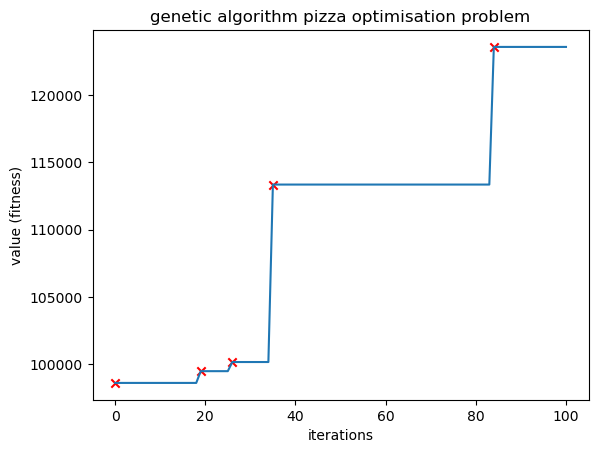

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.title("genetic algorithm pizza optimisation problem")
plt.xlabel("iterations")
plt.ylabel("value (fitness)")
plt.plot(fitnessTrace)
plt.scatter(improvedIterationsTrace, improvedSolutionsFitnessTrace, marker = "x", color = "red")

## Comparing the genetic algorithm to the hill climber algorithm. Does the genetic algorithm outperform, i.e., find better resutls than the hill climber algorithm?

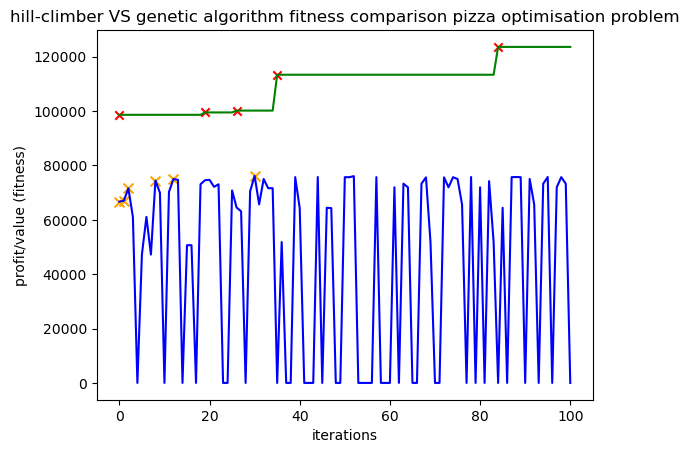

Best solution:
Genetic algorithm: 123585
Hill-climber algorithm: 76172


In [28]:
# comparison plot
plt.title("hill-climber VS genetic algorithm fitness comparison pizza optimisation problem")
plt.xlabel("iterations")
plt.ylabel("profit/value (fitness)")
# genetic algorithm plot
plt.plot(fitnessTrace, color = "green")
plt.scatter(improvedIterationsTrace, improvedSolutionsFitnessTrace, marker = "x", color = "red")
# hill-climber algorithm plot
plt.plot(allSolutionsProfitTrace, color = "blue")
plt.scatter(improvedSolutionsIterationsTrace, improvedSolutionsProfitTrace, color = "orange", s = 50, marker = "x")
plt.show()

print("Best solution:")
print(f"Genetic algorithm: {bestSolution[1]}")
print(f"Hill-climber algorithm: {improvedSolutionsProfitTrace[-1]}")

# Part 3: Performance Comparison
Total: 15 marks (30% of 50 point total)

5pts (10% of marks): Algorithms and Comparing Performance -
What are the two selected algorithm versions?
What did you do to try to make the comparison fair?

10pts (20% of marks): Experiments and Results -
Running experiments and reporting numerical values such as average and standard deviation. Include graphical visualisations of your comparative results

- Here you're given the opportunity to perform a sound comparison of two versions of your algorithm.
- By two versions, I  do not mean two completely different algorithms!
- For example, you can contrast two values of your algorithm hyper-parameters, or two different search operators.
- Please note that
    - The optimisation methods we have studied are stochastic, meaning that any performance comparison needs to consider several runs, at least 10 runs. 
    - In order to have a fair comparison between the two algorithm variants, we need to give them approximately the same computational effort (running time) to solve the problem.
- Base your comparison on the hardest instance.
- To complete this part you should
    - Report in text form  (using markdown cells in your notebook).
        - Briefly describe the two selected algorithm versions.
        - Justify your design of the two selected versions.
        - What did you do to try to make the comparison fair?  
    - Report numerical values such as average and standard deviation.
    - Report plots with your comparative results.  

## Reading in a large dataset for the multi-knapsack problem for a more challenging testing of my algorithm variants
- n = 200
- m = 25

In [29]:
data_file_name = "multi_knap_n200_m25.txt"        

n, m, profits, resources, capacities = read_multi_knapsack(data_file_name)

numberOfRecipes = n
numberOfIngregients = m
recipeProfits = profits
recipeIngredientsQuantities = resources
ingredientsSupply = capacities

## What are the two selected algorithm versions?
The two selected algorithms are two versions of the genetic algorithm implement previous in part 2 of this assignment.

The two algorithm versions will differ in their hyper-parameter values.

## controlled confounding variables
Hyper-parameters are parameters that are not learned by the model but are set prior to training. They control the learning process and affect the performance of the model.
Hyper-parameters include:
- **iterations**
    - The number of times the algorithm will run before stopping.
- **population size**
    - The larger the population of participants, the larger the search space because more potential solutions will be explored.
- **selection pressure**
    - The more participants in the selection process, the higher the selective pressure, i.e., the less likely weak candidates are to be choosen. The higher the selection pressure the quicker the algorithm's rate of convergence towards an optimum solution.
- **replacement rate**
    - The number of individuals in the population that are replaced with new offspring in each generation of the genetic algorithm. A larger value results in a quicker rate of convergence towards an optimum solution, but it could also lead to a loss of chromosome diversity (search space) if the new offspring are not as diverse as the previous generation.
- **crossover rate**
    - The number of crossover points between parents of a child. A higher crossover rate increases the likelihood of genetic material being exchanged between chromosomes, which can lead to faster convergence but also increases the risk of premature convergence and loss of diversity. If the genetic algorithm's rate of convergence is too high it might converge towards an optimum solution too fast, thereby converging to a local optimum solution instead of the global optimum solution.

In [30]:
iterations = 1000
populationSize = 100
selectionPressure = 3
replacementRate = 2
crossoverRate = 3

## independent variables
The independent variables in this genetic algorithm comparison are:
- **mutation rate**
    - The number of random gene mutations in a child. This parameter affects the genetic algorithm mutation rate, which is the probability that a gene will mutate.

### genetic algorithm 1

In [31]:
mutationRate1 = 1

### genetic algorithm 2

In [32]:
mutationRate2 = 6

## Running experiments

In [33]:
# creating histories of algorithm 1 & 2s best solutions and fitness for each test
# algorithm 1 histories
algo1BestSolutions = []
algo1FitnessTraces = []
algo1ImprovedFitnessesTraces = []
algo1ImprovedIterationsTraces = []
algo1ExecutionTimes = []
# algorithm 2 histories
algo2BestSolutions = []
algo2FitnessTraces = []
algo2ImprovedFitnessesTraces = []
algo2ImprovedIterationsTraces = []
algo2ExecutionTimes = []

import time

# running the experiments
numberOfTests = 100
for test in range(numberOfTests):
    # run algorithm 1
    start_time_1 = time.time()
    best1, fitness1, improvedFitnesses1, improvedIterations1 = geneticAlgorithm(iterations,
                                                                            populationSize,
                                                                            selectionPressure,
                                                                            replacementRate,
                                                                            crossoverRate,
                                                                            mutationRate1)
    end_time_1 = time.time()
    algo1BestSolutions.append(best1)
    algo1FitnessTraces.append(fitness1)
    algo1ImprovedFitnessesTraces.append(improvedFitnesses1)
    algo1ImprovedIterationsTraces.append(improvedIterations1)
    algo1_execution_time = end_time_1 - start_time_1
    algo1ExecutionTimes.append(algo1_execution_time)
    
    # run algorithm 2
    start_time_2 = time.time()
    best2, fitness2, improvedFitnesses2, improvedIterations2 = geneticAlgorithm(iterations,
                                                                            populationSize,
                                                                            selectionPressure,
                                                                            replacementRate,
                                                                            crossoverRate,
                                                                            mutationRate2)
    end_time_2 = time.time()
    algo2BestSolutions.append(best2)
    algo2FitnessTraces.append(fitness2)
    algo2ImprovedFitnessesTraces.append(improvedFitnesses2)
    algo2ImprovedIterationsTraces.append(improvedIterations2)
    algo2_execution_time = end_time_2 - start_time_2
    algo2ExecutionTimes.append(algo2_execution_time)

## What did you do to try to make the comparison fair?
To make the comparison fair confounding variables will be kept constant.

This way differences in outcome (performance) between the two versions of the genetic algorithm can only be attributed to the differences between them, i.e., the different values of their independent varialbes, and not to confounding variables that affect the performance of these genetic algorithms.

The independent variables in this comparison will be some of the hyper-parameters shared by the two genetic algorithms. I will assign the indepent variables differnet values for each algorithm and compare the results.

All other variables will be the same for both algorithms. Including other hyper-parameters. For example, both algorithms will run for the same number of iterations and have the same population size. 

This comparison format means observable differences in outcomes between the two genetic algorithms can be attributed to the only differences between them, the value of their independent variables.

Additionally, I will run the same experiment (performance test) multiple times. This way I will be comparing the average results of both genetic algorithms, and not just one-time results. This is important because otherwise I could be comparing an exceptional result from one version of the algorithm with a below average result from the other version. This would be an unfair and inaccurate because I would be comparing a lucky result with an unlucky result.

Comparing the results of multiple tests demonstrates that the observations are not one time flukes. This makes the comparison fair and accurate because it gives us the ability to deduce which algorithm is best most of the time. Thereby removing luck from the comparison the more experiments we run.

## Reporting numerical values such as average and standard deviation. Include graphical visualisations of your comparative results

### algorithms numerical metrics results comparison

#### Average best solution

In [34]:
algo1BestSolutionFitnesses = [bestSolution[1] for bestSolution in algo1BestSolutions]
averageBestAlgo1 = np.average(algo1BestSolutionFitnesses)
overallBestSolutionAlgo1 = max(algo1BestSolutionFitnesses)
print("Algorithm 1:")
print(f"Average of best solutions: {averageBestAlgo1}")
print(f"Overall best solution: {overallBestSolutionAlgo1}")
print()

algo2BestSolutionFitnesses = [bestSolution[1] for bestSolution in algo2BestSolutions]
averageBestAlgo2 = np.average(algo2BestSolutionFitnesses)
overallBestSolutionAlgo2 = max(algo2BestSolutionFitnesses)
print("Algorithm 2:")
print(f"Average of best solutions: {averageBestAlgo2}")
print(f"Overall best solution: {overallBestSolutionAlgo2}")

Algorithm 1:
Average of best solutions: 7651.8
Overall best solution: 7827

Algorithm 2:
Average of best solutions: 7643.39
Overall best solution: 7740


#### Standard deviation from the average best solution

In [35]:
stdDevBestSolutionsAlgo1 = np.std(algo1BestSolutionFitnesses)
print(f"Standard deviation of best solutions from algorithm 1: {stdDevBestSolutionsAlgo1}")

stdDevBestSolutionsAlgo2 = np.std(algo2BestSolutionFitnesses)
print(f"Standard deviation of best solutions from algorithm 2: {stdDevBestSolutionsAlgo2}")

Standard deviation of best solutions from algorithm 1: 59.56592985927441
Standard deviation of best solutions from algorithm 2: 45.397994449094334


#### Average execution duration

In [36]:
averageRunTimeAlgo1 = np.average(algo1ExecutionTimes)
averageRunTimeAlgo2 = np.average(algo2ExecutionTimes)
print(f"Average run time of algorithm 1: {averageRunTimeAlgo1} seconds.")
print(f"Average run time of algorithm 2: {averageRunTimeAlgo2} seconds.")

Average run time of algorithm 1: 2.2657977080345155 seconds.
Average run time of algorithm 2: 2.290707070827484 seconds.


When comparing algorithms run time gives us an idea of the efficiency of our algorithms. I.e., how much work they require to execute.

The two algorithms presented for solving this instance of the knapsack problem have a negligible difference in execution duration.

A difference of less than 0.05 seconds may seem negligible, but it depends on the context in which the algorithm is used. In this scenario this difference is not meaningful. However, if these algorithms were running on a large scale or in a time sensitive application, small differences like this can add up or become significant. For example, if an algorithm runs millions of times a 0.01 second difference can lead to a substantial total time difference. However, if the algorithms are not frequently executed, this difference might not be as significant.

### Graphical visualisations of comparative resutls

#### comparison of best solutions box plot
The box plot comparing the best solutions from both algorithms shows the distribution of fitnesses for each of the algorithms.

A boxplot is a graphical representation of the distribution of a set of data based on a five-number summary:
- minimum
- first quartile (Q1)
- median
- third quartile (Q3)
- maximum

A boxplot can tell you about outliers (circles above or below the box plot), skewness (where is the usually orange median line relative to the other data points), and the distribution of values across multiple data streams (in this case the distribution of best solutions for algorithms 1 and 2).
In these box plots:
- The box represents the interquartile range (IQR), which is the range between the first quartile (25th percentile) and the third quartile (75th percentile). This gives you a sense of where the bulk of your data falls.
- The line inside the box represents the median (50th percentile), which is the middle value of the data set.
- The "whiskers" extending from the box show the range within which the majority of the data falls, typically within 1.5 times the IQR of the data.
- Any data points that fall outside the whiskers are considered outliers and are typically marked with a different symbol. Usually a circle.

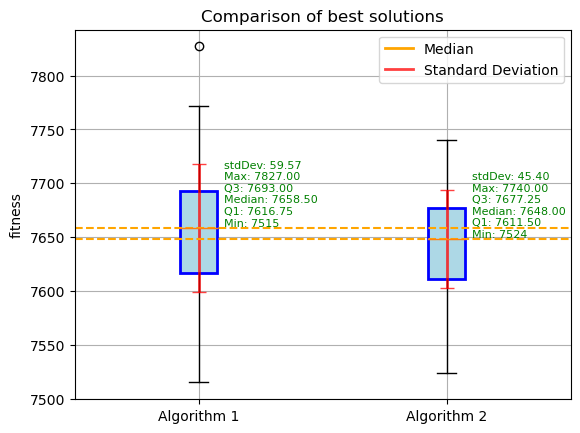

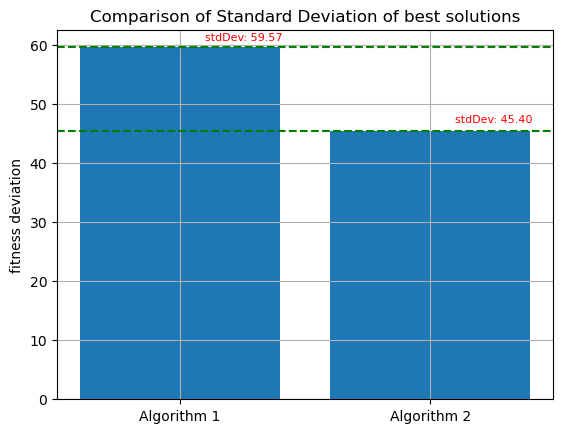

In [37]:
# box plot comparing the distributions of best solutions for each algorithm

# computing the minimum, maximum, and quartile values for each algorithm
algo1Stats = np.percentile(algo1BestSolutionFitnesses, [25, 50, 75]), np.min(algo1BestSolutionFitnesses), np.max(algo1BestSolutionFitnesses), np.std(algo1BestSolutionFitnesses)
algo2Stats = np.percentile(algo2BestSolutionFitnesses, [25, 50, 75]), np.min(algo2BestSolutionFitnesses), np.max(algo2BestSolutionFitnesses), np.std(algo2BestSolutionFitnesses)

# creating the box plot
figure, axes = plt.subplots() # axes is an instance of the Axes class which represents a single plot in a figure
axes.boxplot([algo1BestSolutionFitnesses, 
              algo2BestSolutionFitnesses], 
              labels=['Algorithm 1', 'Algorithm 2'],
              patch_artist=True,
              boxprops=dict(facecolor='lightblue', color='blue', linewidth=2))

# adding error bars to the box plot to show the standard deviation of best solutions for each algorithm
axes.errorbar(1, algo1Stats[0][1], yerr=algo1Stats[3], color=(1, 0, 0, 0.75), capsize=5, lw=2)
axes.errorbar(2, algo2Stats[0][1], yerr=algo2Stats[3], color=(1, 0, 0, 0.75), capsize=5, lw=2)

# making custom legend handles
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='orange', lw=2, label='Median'),
                   Line2D([0], [0], color=(1, 0, 0, 0.75), lw=2, label='Standard Deviation')]
# adding the legend
axes.legend(handles=legend_elements, loc='upper right')

# Add labels, lines, and grid
axes.set_xticklabels(['Algorithm 1', 'Algorithm 2'])
axes.axhline(y = algo1Stats[0][1], color = 'orange', linestyle = '--', label = 'Median')
axes.axhline(y = algo2Stats[0][1], color = 'orange', linestyle = '--', label = 'Median')
axes.text(1.1, algo1Stats[0][1], 
          f'stdDev: {algo1Stats[3]:.2f}\nMax: {algo1Stats[2]:.2f}\nQ3: {algo1Stats[0][2]:.2f}\nMedian: {algo1Stats[0][1]:.2f}\nQ1: {algo1Stats[0][0]:.2f}\nMin: {algo1Stats[1]}', 
          verticalalignment='bottom', fontsize=8, color="green")
axes.text(2.1, algo2Stats[0][1], 
          f'stdDev: {algo2Stats[3]:.2f}\nMax: {algo2Stats[2]:.2f}\nQ3: {algo2Stats[0][2]:.2f}\nMedian: {algo2Stats[0][1]:.2f}\nQ1: {algo2Stats[0][0]:.2f}\nMin: {algo2Stats[1]}', 
          verticalalignment='bottom', fontsize=8, color="green")
axes.grid(True)

# drawing the box plot
plt.title('Comparison of best solutions')
plt.ylabel('fitness')
plt.show()

# bar plot comparing standard deviations of best solutions from algorithm 1 & 2
plt.bar([1, 2], 
        [stdDevBestSolutionsAlgo1, 
         stdDevBestSolutionsAlgo2], 
        tick_label=['Algorithm 1', 'Algorithm 2'])
plt.axhline(y = algo1Stats[3], color = 'green', linestyle = '--', label = 'Standard Deviation')
plt.axhline(y = algo2Stats[3], color = 'green', linestyle = '--', label = 'Standard Deviation')
plt.text(1.1, algo1Stats[3] * 0.98, f'stdDev: {algo1Stats[3]:.2f}\n', verticalalignment='bottom', fontsize=8, color="red")
plt.text(2.1, algo2Stats[3] * 0.98, f'stdDev: {algo2Stats[3]:.2f}\n', verticalalignment='bottom', fontsize=8, color="red")
plt.grid(True)
plt.ylabel('fitness deviation')
plt.title('Comparison of Standard Deviation of best solutions')
plt.show()

## comparison experiment conclusion
The independent variable was mutation rate:
- The number of random gene mutations in a child. This parameter affects the genetic algorithm mutation rate, which is the probability that a gene will mutate.

mutation rates:
- algorithm 1: 1
- algortihm 2: 6

The control variables were:
- iterations = 1000
- populationSize = 100
- selectionPressure = 3
- replacementRate = 2
- crossoverRate = 3

The results of this controlled comparison experiment indicate that a lower mutation rate of 1 is preferable to a greater mutation rate of 6. Because the algorithm with the lower mutation rate outperformed the algorithm with a greater mutation rate the majority of times.

However, the difference in performance is very small relative to total performance. Which indicates that a mutation rate of 1 or 6 has little impact on performance given the controlled hyper-parameters.

# Submission Guidelines
- You can work on your own
- Or in a team of 2 people, if you decide to do so
    - Register your team at Project Groups
    - A single submission per team is required
- Submit two files
    - A Jupyter notebook (.ipynb) (to check your code)
    - An HTML version of the notebook to facilitate reading 
- Identify the team student number(s) in your notebook.
- Avoid submitting notebooks with very long output printouts.
- Use markdown to identify the parts of the assignment clearly.
- It would be best if you used code cells for your code and markdown cells to answer the questions in text form. 

reiteration of guidelines:
- Submit a single Jupyter document (.ipynb), clearly identifying each part using markdown cells. 
- Submit also an HTML version of your notebook to facilitate reading and initial inspection.
- Use code cells for your code and plots, and markdown cells for your text descriptions and justification of design choices.

#### Due 15 Nov by 23:59